# Evaluate four contractions

Here we want to evaluate the impact on the performances of doing four contraction blocks instead of three.

As usual, we work on the MNIST test set binarized (normal class: 0 vs. all the other digits) and use the AU-ROC metrics to compare the model performances.

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.random import normal
import tensorflow.keras as keras

from tensorflow.keras import Model, layers
from tensorflow.keras.datasets import mnist

print(tf.__version__)

from google.colab import drive
drive.mount('/content/gdrive')

import sys
sys.path.append('/content/gdrive/My Drive/BACMMAN_DISTNET/')

from uad.callbacks.classification import AUCCallback
from uad.MNIST.draw_line import set_anomaly, predict_anomalies, contour_anomalies, plot_anomalies
from uad.metrics.AU_ROC import compute_ROC, compute_AUC, plot_ROC
from uad.MNIST.one_vs_all import plot_prediction, plot_per_digit_proportion
from uad.decision.reconstruction import is_anormal, decision_function, binarize_set
from uad.models.variational_autoencoder import ConvolutionalVAE
from uad.visualisation.tSNE import plot_tSNE

!nvidia-smi

2.2.0
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Mon Jul 13 19:08:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

x_val, y_val = x_train[-1000:], binarize_set(y_train[-1000:], interest=0)
y_test0 = binarize_set(y_test)

# train set sorted by digits: digits_train[i] = x_train elements where y_train == i
digits_train = np.array([x_train[np.where(y_train[:-1000] == i)] for i in range(10)])

# training set contains only zeros (for training on zeros)
x_train0, y_train0 = digits_train[0][:-1000], y_train[np.where(y_train[:-1000] == 0)][:-1000]

print(x_train0.shape, y_train0.shape, x_val.shape, y_val.shape)
print(y_test[:5], y_test0[:5])

11493376/11490434 [==============================] - 0s 0us/step
(4825, 28, 28, 1) (4825,) (1000, 28, 28, 1) (1000,)
[7 2 1 0 4] [1 1 1 0 1]


In [ ]:
from uad.models.variational_autoencoder import VAE, Sampling

def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True, activation1="sigmoid",
                 activation2="sigmoid"):
    """Function to add 2 convolutional layers with the parameters passed to it
    activation1: name of the activation function to apply. If none, pass "" (empty string)
    activation2: name of the activation function to apply. If none, pass "" (empty string)
    """
    # first layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation1 != "":
        x = layers.Activation(activation1)(x)

    # second layer
    x = layers.Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), \
                      kernel_initializer='he_normal', padding='same')(input_tensor)
    if batchnorm:
        x = layers.BatchNormalization()(x)
    if activation2 != "":
        x = layers.Activation(activation2)(x)

    return x

def build_VAE(n_filters=16, n_contractions=3):
    latent_dim = 8
    latent_side = int(2 ** (5 - n_contractions))  
    batchnorm = False
    dropout = 0.2
    k_size = 3

    act1, act2, final_activation = "sigmoid", "sigmoid", "sigmoid"

    encoder_inputs = layers.Input(shape=(28, 28, 1), name="encoder_inputs")

    paddings = tf.constant([[0, 0], [2, 2], [2, 2], [0, 0]])  # shape d x 2 where d is the rank of the tensor and 2 represents "before" and "after"
    x = tf.pad(encoder_inputs, paddings, name="pad")

    for k in range(n_contractions):
        x = conv2d_block(x, n_filters * (2**k), kernel_size=k_size, batchnorm=batchnorm, 
                     activation1=act1, activation2=act2)
        x = layers.MaxPooling2D((2, 2))(x)
        x = layers.Dropout(dropout)(x)

    z_mean = layers.Conv2D(latent_dim, 1, strides=1, name="z_mean")(x)
    z_log_var = layers.Conv2D(latent_dim, 1, strides=1, name="z_log_var")(x)
    z = Sampling()((z_mean, z_log_var))

    encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

    # Define decoder model.
    latent_inputs = layers.Input(shape=(latent_side, latent_side, latent_dim), 
                                 name="z_sampling")
    x = latent_inputs
    
    for k in range(n_contractions, 0, -1):
        x = layers.Conv2DTranspose(n_filters * (2**(k - 1)), (k_size, k_size), strides=(2, 2), 
                               padding='same', name=f"u{n_contractions + k}")(x)
        x = layers.Dropout(dropout)(x)
        if k == 1:
            decoder_outputs = conv2d_block(x, 1, kernel_size=k_size, batchnorm=batchnorm, 
                              activation1=act1, activation2=act2)
        else:
            x = conv2d_block(x, n_filters * (2**(k - 1)), kernel_size=k_size, batchnorm=batchnorm, 
                              activation1=act1, activation2=act2)

    crop = tf.image.resize_with_crop_or_pad(decoder_outputs, 28, 28)

    decoder = Model(inputs=latent_inputs, outputs=crop, name="decoder")

    return VAE(encoder, decoder, latent_dim=latent_dim)


In [ ]:
tested_config = np.array([[16, 3], # 3 contraction with intially 16 filters 
                          [8, 4], # 4 contraction with intially 8 filters : ~same # parameters
                          [16, 4],
                          [8, 3]])

models, l_fpr, l_tpr, l_auc = [], [], [], []
for n_filters, n_contractions in tested_config:
    print(f"# Filters: {n_filters}, # Contractions: {n_contractions}")
    vae = build_VAE(n_filters=n_filters, n_contractions=n_contractions)
    vae.compile(optimizer=tf.keras.optimizers.Adam())
    vae.fit(x_train0, x_train0, batch_size=128, epochs=30)
    predictions = vae.predict(x_test)
    fpr, tpr, _ = compute_ROC(x_test, predictions, y_test0, criterion="l2")
    auc = compute_AUC(fpr, tpr)
    models.append(vae)
    l_fpr.append(fpr)
    l_tpr.append(tpr)
    l_auc.append(auc)
    
fprs, tprs, aucs = np.array(l_fpr), np.array(l_tpr), np.array(l_auc)

print(aucs)

# Filters: 16, # Contractions: 3
Epoch 1/30
38/38 [==============================] - 0s 10ms/step - loss: 382.8148 - reconstruction_loss: 382.5257 - kl_loss: 0.2891
Epoch 2/30
38/38 [==============================] - 0s 7ms/step - loss: 324.9503 - reconstruction_loss: 323.7403 - kl_loss: 1.2100
Epoch 3/30
38/38 [==============================] - 0s 7ms/step - loss: 245.1555 - reconstruction_loss: 243.2214 - kl_loss: 1.9341
Epoch 4/30
38/38 [==============================] - 0s 7ms/step - loss: 211.9575 - reconstruction_loss: 210.0598 - kl_loss: 1.8976
Epoch 5/30
38/38 [==============================] - 0s 7ms/step - loss: 165.4917 - reconstruction_loss: 163.0609 - kl_loss: 2.4308
Epoch 6/30
38/38 [==============================] - 0s 7ms/step - loss: 138.5103 - reconstruction_loss: 135.6313 - kl_loss: 2.8790
Epoch 7/30
38/38 [==============================] - 0s 7ms/step - loss: 124.5831 - reconstruction_loss: 121.5639 - kl_loss: 3.0192
Epoch 8/30
38/38 [==============================]

In [ ]:
import os
os.chdir("/content/gdrive/My Drive/BACMMAN_DISTNET/UAD/MNIST/saved_models")

tf.keras.models.save_model(models[0], "vae_16_3")
tf.keras.models.save_model(models[1], "vae_8_4")
tf.keras.models.save_model(models[2], "vae_16_4")
tf.keras.models.save_model(models[3], "vae_8_3")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: vae_16_3/assets
INFO:tensorflow:Assets written to: vae_8_4/assets
INFO:tensorflow:Assets written to: vae_16_4/assets
INFO:tensorflow:Assets written to: vae_8_3/assets


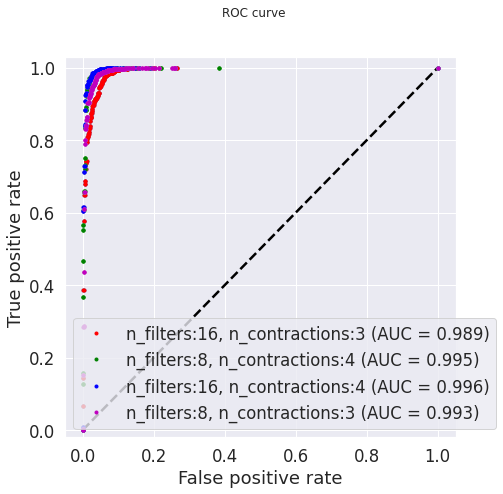

In [ ]:
# plot ROC for each dim
labels = [f"n_filters:{row[0]}, n_contractions:{row[1]}" for row in tested_config]
fig, ax = plot_ROC(fprs, tprs, labels)

In [ ]:
vae_16_3 = models[0]
vae_8_4 = models[1]
vae_16_4 = models[2]
vae_8_3 = models[3]

pred_16_3 = vae_16_3.predict(x_test)
pred_8_4 = vae_8_4.predict(x_test)
pred_16_4 = vae_16_4.predict(x_test)
pred_8_3 = vae_8_3.predict(x_test)

In [ ]:
print(models[3].summary())

Model: "vae_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Model)              [(None, 4, 4, 8), (None,  6416      
_________________________________________________________________
decoder (Model)              (None, 28, 28, 1)         19761     
Total params: 26,177
Trainable params: 26,177
Non-trainable params: 0
_________________________________________________________________
None


Text(0.5, 1.0, '8 filters, 3 contractions')

<Figure size 432x288 with 0 Axes>

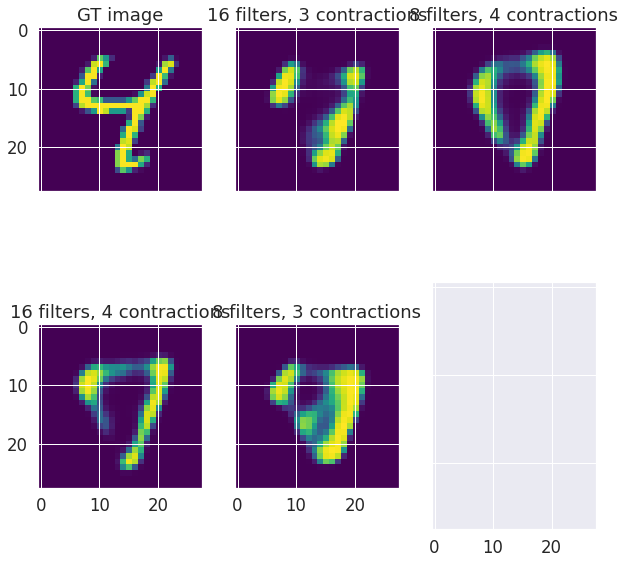

In [ ]:
# pred_16_3 = np.squeeze(pred_16_3, -1)
# pred_8_4 = np.squeeze(pred_8_4, -1)
# pred_16_4 = np.squeeze(pred_16_4, -1)
# pred_8_3 = np.squeeze(pred_8_3, -1)
# x_test = np.squeeze(x_test, -1)

plt.viridis()

idx = 6
fig, ax = plt.subplots(2, 3, figsize=(10, 10), sharey="all", sharex="all")
ax[0][0].imshow(x_test[idx])
ax[0][0].set_title("GT image")
ax[0][1].imshow(pred_16_3[idx])
ax[0][1].set_title("16 filters, 3 contractions")
ax[0][2].imshow(pred_8_4[idx])
ax[0][2].set_title("8 filters, 4 contractions")
ax[1][0].imshow(pred_16_4[idx])
ax[1][0].set_title("16 filters, 4 contractions")
ax[1][1].imshow(pred_8_3[idx])
ax[1][1].set_title("8 filters, 3 contractions")

Text(0.5, 1.0, '8 filters, 3 contractions')

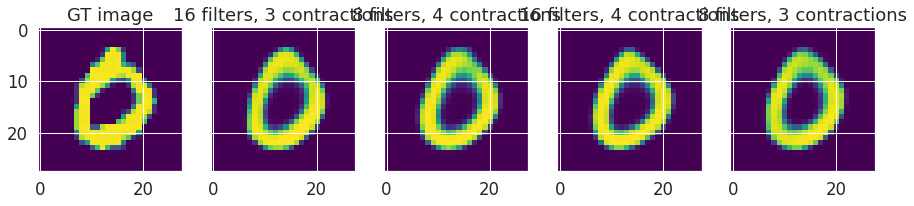

In [ ]:
idx = 3
fig, ax = plt.subplots(1, 5, figsize=(15, 15), sharey="all", sharex="all")
ax[0].imshow(x_test[idx])
ax[0].set_title("GT image")
ax[1].imshow(pred_16_3[idx])
ax[1].set_title("16 filters, 3 contractions")
ax[2].imshow(pred_8_4[idx])
ax[2].set_title("8 filters, 4 contractions")
ax[3].imshow(pred_16_4[idx])
ax[3].set_title("16 filters, 4 contractions")
ax[4].imshow(pred_8_3[idx])
ax[4].set_title("8 filters, 3 contractions")

We make several observations:
- The result of the measure is partially random due to the randomness in the training. Rigorously we should repeat the experience several times and take a mean ROC. 
- The performances of each model is comparable with a suffieciently long trainig (here 30 epochs). For a shorter training, the model with 16 filters and 4 contractions performs poorer due to its higher number of parameters (around 300,000 vs. 100,000 for the models 16 filters/3 contractions and 8 filters/4 contractions.
- The model 8 filters/4 contractions seems to perform a bit better than the initial choice 16 filters/3 contractions with almost the same number of parameters.
- The learning in the 16/3 model seems less "complete" than for the others, since all the non-zero digits are less transformed into zeros in this case. We should investigate further whether this a strength or a weakness of this model. Intuitively, it seems a weakness (compared to the other models) since the non-zero digits are less separated from their ego initiali. On the other hand, it could be a strength on poorly drawn zeros, which could be mistakenly separate from their reconstruction.

t-SNE inputs shape: (10000, 128)
t-SNE inputs shape: (10000, 4)
t-SNE inputs shape: (10000, 4)
t-SNE inputs shape: (10000, 8)


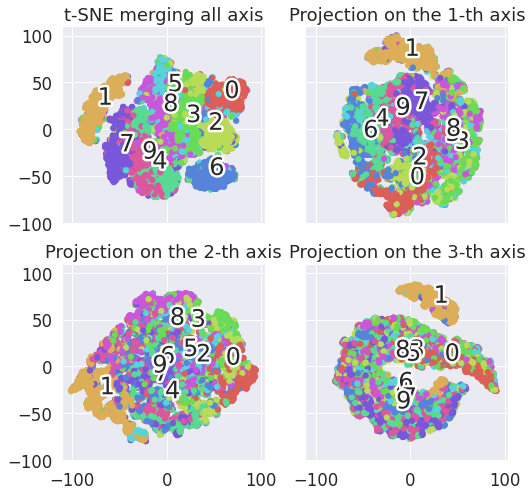

In [ ]:
z_means_16_3, _, _ = vae_16_3.encoder.predict(x_test)

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharey="all", sharex="all")

for i, ax in enumerate(axes.flatten()):
  plot_tSNE(z_means_16_3, y_test, axis=i, plt_ax=ax)
  if i == 0:
    ax.set_title("t-SNE merging all axis")
  else:
    ax.set_title(f"Projection on the {i}-th axis")

t-SNE inputs shape: (10000, 32)
t-SNE inputs shape: (10000, 2)
t-SNE inputs shape: (10000, 2)
t-SNE inputs shape: (10000, 8)


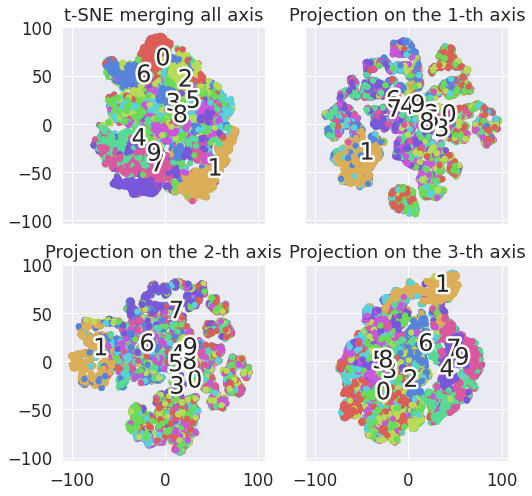

In [ ]:
z_means_8_4, _, _ = vae_8_4.encoder.predict(x_test)

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharey="all", sharex="all")

for i, ax in enumerate(axes.flatten()):
  plot_tSNE(z_means_8_4, y_test, axis=i, plt_ax=ax)
  if i == 0:
    ax.set_title("t-SNE merging all axis")
  else:
    ax.set_title(f"Projection on the {i}-th axis")

t-SNE inputs shape: (10000, 32)
t-SNE inputs shape: (10000, 2)
t-SNE inputs shape: (10000, 2)
t-SNE inputs shape: (10000, 8)


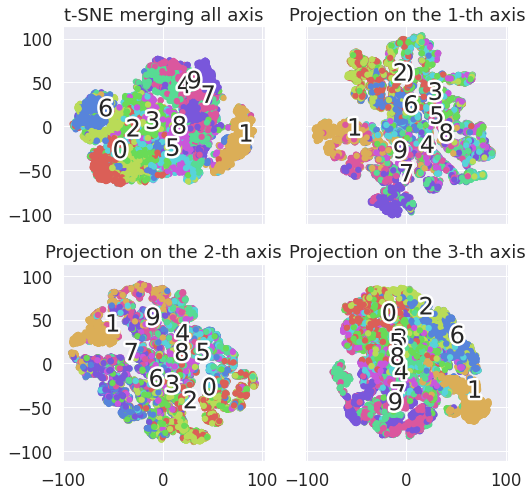

In [ ]:
z_means_16_4, _, _ = vae_16_4.encoder.predict(x_test)

fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharey="all", sharex="all")

for i, ax in enumerate(axes.flatten()):
  plot_tSNE(z_means_16_4, y_test, axis=i, plt_ax=ax)
  if i == 0:
    ax.set_title("t-SNE merging all axis")
  else:
    ax.set_title(f"Projection on the {i}-th axis")